In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
import numpy as np
import torch
from torch import nn
import torch
import time
import unet

import swyft
import pylab as plt
import scipy.stats.distributions as dist

from astropy.visualization import make_lupton_rgb

torch.set_float32_matmul_precision('medium')
DEVICE = "cuda"

### Generative model

In [11]:
bounds = None

In [12]:
class SimulatorBlob(swyft.Simulator):
    def __init__(self, bounds = None, Npix = 64, sigma = 0.1):
        super().__init__()
        self.transform_samples = swyft.to_numpy32
        self.theta_sampler = swyft.RectBoundSampler([dist.uniform(4., 0.1)])
        self.bounds = bounds
        self.Npix = Npix
        self.sigma = sigma
        self.powersampler = swyft.utils.PowerSpectrumSampler(Npix)
        self.sigma = torch.ones(Npix, Npix)*0.1
#        self.sigma[:,:Npix//2] *= 1000
        
    def sample_delta(self, theta):
        if self.bounds is not None:
            i = np.random.randint(len(self.bounds))
            return torch.tensor(self.bounds[i])
        else:
            return self.powersampler.sample(lambda k: 1e6*3*(k/0.5)**-theta[0])
            
    def build(self, graph):
        theta = graph.node("theta", self.theta_sampler)
        delta1 = graph.node("delta1", self.sample_delta, theta)
        delta2 = graph.node("delta2", self.sample_delta, theta)
        rho1 = graph.node("rho1", lambda delta1: torch.exp(delta1/2).unsqueeze(0)*torch.tensor([0, 2, 5]).view(3, 1, 1), delta1)
        rho2 = graph.node("rho2", lambda delta2: torch.exp(delta2/2).unsqueeze(0)*torch.tensor([5, 2, 0]).view(3, 1, 1), delta2)
        mu = graph.node("mu", lambda rho1, rho2: rho1 + rho2, rho1, rho2)
        x = graph.node("x", lambda mu: mu + torch.randn(self.Npix, self.Npix)*self.sigma, mu)

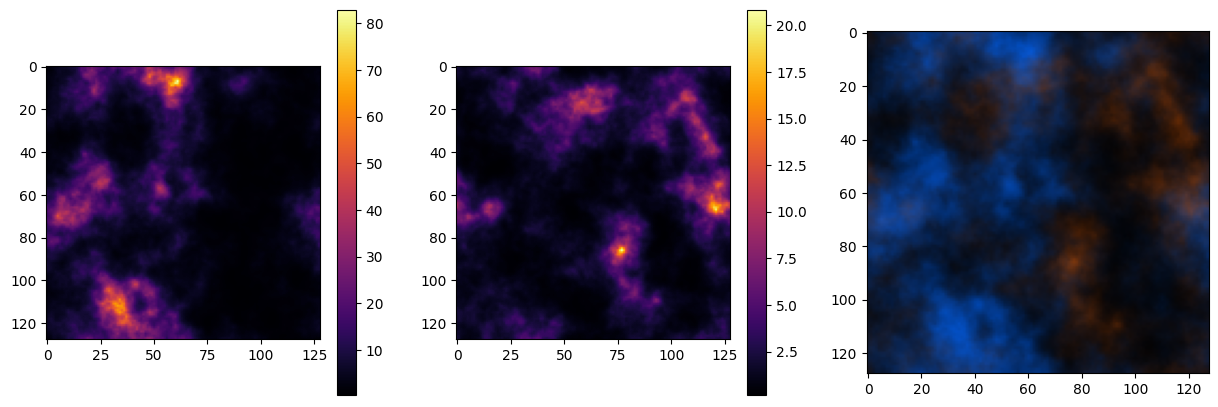

In [13]:
NPIX = 128
sim = SimulatorBlob(Npix = NPIX)
sample0 = sim.sample()
plt.figure(figsize = (15, 5))
plt.subplot(131)
plt.imshow(sample0['rho1'].mean(0), cmap = 'inferno')
plt.colorbar()
plt.subplot(132)
plt.imshow(sample0['rho2'].mean(0), cmap = 'inferno')
plt.colorbar()
plt.subplot(133)

#img = torch.tensor(sample0['x']).permute(1, 2, 0)
#img = img/img.max()
img = torch.tensor(sample0['x'])
img = img/img.max()
img = make_lupton_rgb(img[0], img[1], img[2], stretch=0.3, Q = 10)
plt.imshow(img)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 412.11it/s]


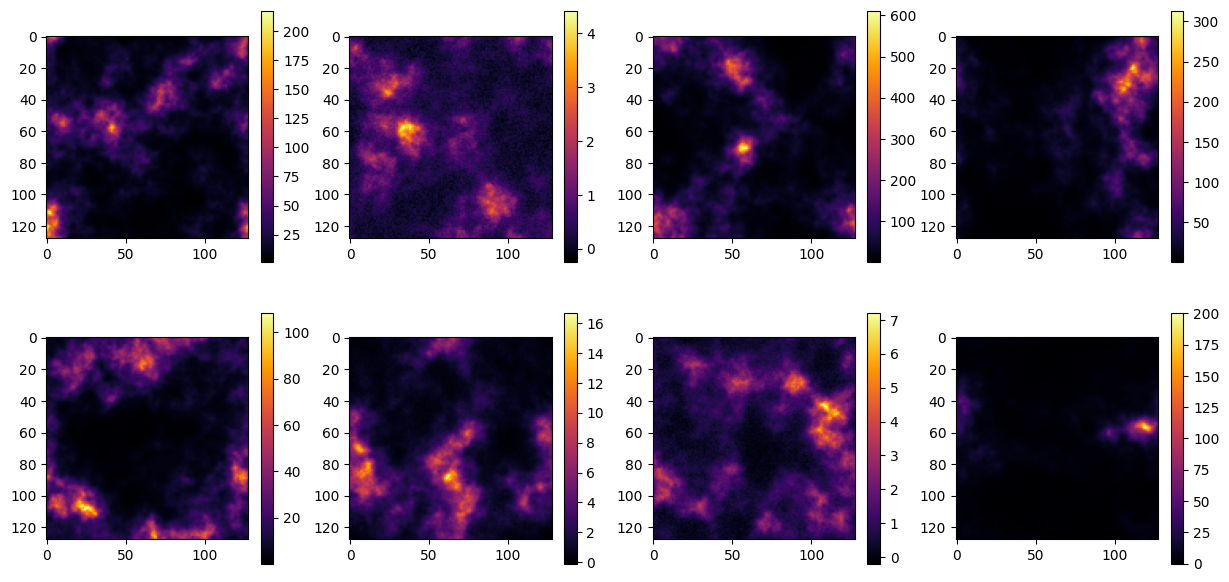

In [14]:
#NPIX = 128
sim = SimulatorBlob(Npix = NPIX, bounds = bounds)
samples = sim.sample(8)
plt.figure(figsize = (15, 15))
for i in range(8):
    plt.subplot(4, 4, i+1)
    plt.imshow(samples[i]['x'][0], cmap = 'inferno')
    plt.colorbar()

### Inference network

In [17]:
class Network(swyft.SwyftModule):
    def __init__(self, lr=1e-3, N = 1024):
        super().__init__()
        self.optimizer_init = swyft.AdamOptimizerInit(lr=1e-4, lrs_factor=0.1, lrs_patience=3)
        self.N = N
        L = lambda x: x*0  # Autoregressive no non-regressive
        self.conv = StrideConv(l_max = 1)
        self.Phi = lambda x: self.conv(x.view(-1, N, N)).view(-1, N*N)
        self.PhiT = lambda x: self.conv.T(x.view(-1, N, N)).view(-1, N*N)
        self.lre = swyft.LogRatioEstimator_Gaussian_Autoregressive_X_module_based(
            self.N**2, "mu", Phi = self.Phi, PhiT = self.PhiT, L = L, minstd = 1e-5, momentum=0.02)
        self.unet = unet.UNet(1, 1, s = 2)
        
    def embed(self, x):
        return torch.log(torch.abs(x)).view(-1, self.N**2)
#        x = self.unet(x.unsqueeze(1)).view(-1, self.N**2)
        #x = x.view(-1, self.N**2)
        #return x

    def forward(self, A, B):
        N = self.N
#        rhoA = A['x'].view(-1, N**2)
#        rhoB = B['x'].view(-1, N**2)
#        rhoA = self.unet(A['x'].unsqueeze(1)).view(-1, N**2)
#        rhoB = self.unet(B['x'].unsqueeze(1)).view(-1, N**2)
        rhoA = self.embed(A['x'])
        rhoB = self.embed(B['x'])
        
        deltaB = B['delta'].view(-1, N**2)
        result = self.lre(rhoA, rhoB, deltaB)
        return result

### Inference

In [115]:
#sim = SimulatorBlob(Npix = NPIX)
samples = sim.sample(1000)
dm = swyft.SwyftDataModule(samples, fractions = [0.9, 0.1, 0.0], batch_size = 64)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 932.03it/s]


In [116]:
net = Network(N = NPIX)

In [117]:
trainer = swyft.SwyftTrainer(accelerator = "gpu", devices = 1, max_epochs = 2)
trainer.fit(net, dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type                                                     | Params
----------------------------------------------------------------------------------
0 | conv | StrideConv                                               | 18    
1 | lre  | LogRatioEstimator_Gaussian_Autoregressive_X_module_based | 0     
2 | unet | UNet                                                     | 7.8 M 
----------------------------------------------------------------------------------
7.8 M     Trainable params
0         Non-trainable params
7.8 M     Total params
31.050    Total estimated model params size (MB)


Epoch 0:  88%|████████████████████████████████████████████████████████████████████████████████████▋           | 15/17 [00:00<00:00, 17.21it/s, loss=-1.95e+03, v_num=153]
Validation: 0it [00:00, ?it/s]
Epoch 1:  88%|███████████████████████████████████████████████████████████████████▉         | 15/17 [00:00<00:00, 17.49it/s, loss=-2.17e+03, v_num=153, val_loss=-2.11e+3]
Validation: 0it [00:00, ?it/s]
Epoch 1: 100%|██████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 17.38it/s, loss=-2.17e+03, v_num=153, val_loss=-2.1e+3]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████████████████████████████████████████████████████████████████████████| 17/17 [00:01<00:00, 16.17it/s, loss=-2.17e+03, v_num=153, val_loss=-2.1e+3]


### Evaluation

In [121]:
net.cuda()
net.double()
x = sample0['x']
y = net.embed(torch.tensor(x).cuda().double().unsqueeze(0))[0]
G1Tt, D1, G1t, b = net.lre.get_likelihood_components(y)
G1T = lambda x: G1Tt(x.unsqueeze(0))[0]
G1 = lambda x: G1t(x.unsqueeze(0))[0]

k = PowerSampler(NPIX).k
D2 = 3*(k/0.5)**-4.042*1e6
D2 = D2.view(-1).double().cuda()

N = NPIX
U2 = lambda x: torch.fft.fft2(x.view(N, N), norm = 'ortho').view(N*N)
U2T = lambda x: torch.fft.ifft2(x.view(N, N), norm = 'ortho').view(N*N)

In [125]:
geda = swyft.utils.GEDASampler(0.5/D1.max().item(), G1, D1, G1T, U2, 1/D2, U2T)
draws = geda.sample(4, steps = 500, reset = False, initialize_with_Q2 = True)
print([d.std().item() for d in draws])

[0.5774138707713766, 0.5771296638305847, 0.5862874017677445, 0.5733227964807809]


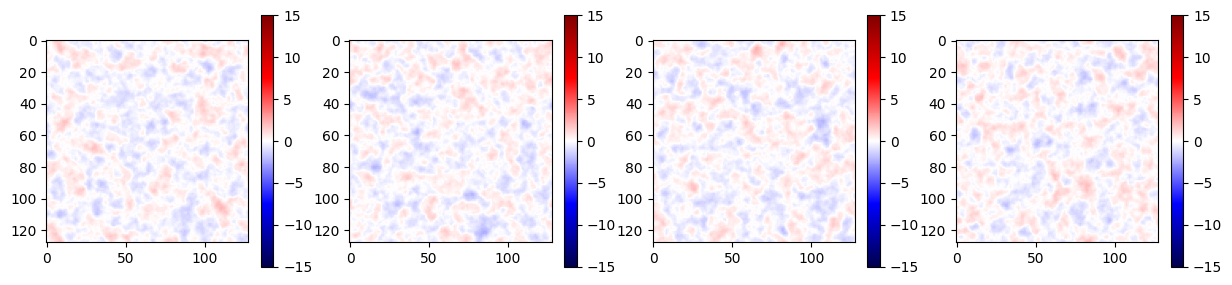

In [126]:
v = 15
plt.figure(figsize = (15, 15))
for i in range(4):
    plt.subplot(4, 4, i+1)
    plt.imshow((draws[i].view(N, N).cpu())[:, :], vmin = -v, vmax = v, cmap = 'seismic')
    plt.colorbar()

In [141]:
COUNTER = 0
def A(x):
    global COUNTER
    COUNTER += 1
    x = x[0,:,0]
    x1 = U2(x).detach()
    x1 *= 1/D2
    x1 = U2T(x1).real.detach()
    x2 = G1(x).detach()
    x2 *= D1
    x2 = G1T(x2).detach()
    x = x1 + x2
    return x.view(1, -1, 1).detach()

In [159]:
cg = swyft.utils.CG(A, rtol = 0.001, atol = None, verbose = False, maxiter = 1000000)
B0 = b.cuda().view(1, -1, 1).detach()
x0 = cg.forward(B0, X0 = B0)
print(COUNTER); COUNTER = 0

TypeError: unsupported operand type(s) for *: 'NoneType' and 'Tensor'

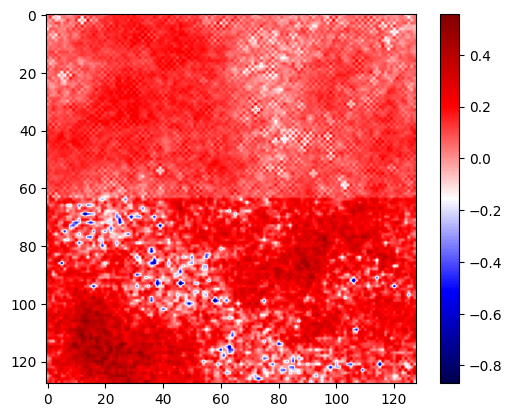

In [155]:
plt.imshow(x0.view(NPIX, NPIX).cpu().detach(), cmap = 'seismic')
plt.colorbar()

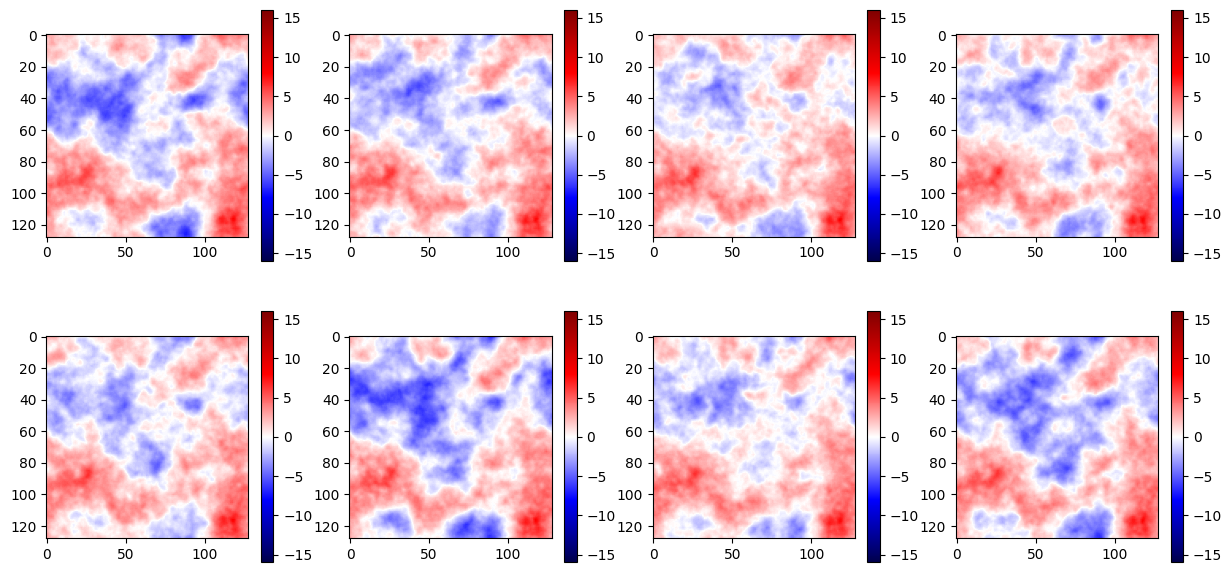

In [198]:
plt.figure(figsize = (15, 15))
for i in range(8):
    plt.subplot(4, 4, i+1)
    plt.imshow(x0.view(NPIX, NPIX).cpu().detach() + draws[i].view(NPIX, NPIX).cpu(), cmap = 'seismic', vmin = -v, vmax = v)
    plt.colorbar()

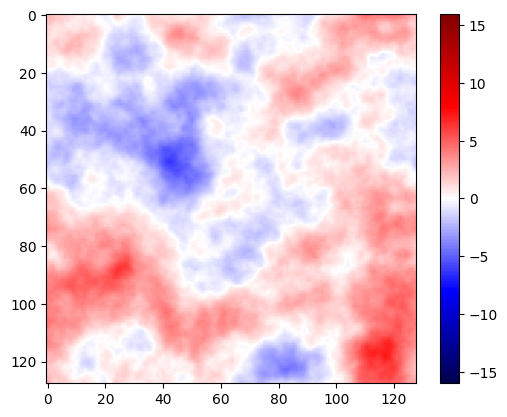

In [199]:
plt.imshow(sample0['delta'], cmap = 'seismic', vmin = -v, vmax = v)
plt.colorbar()

In [200]:
geda = swyft.utils.GEDASampler(epsilon, G1, D1, G1T, U2, 1/D2, U2T)
draws = geda.sample(1000, steps = 100, reset = True)
bounds = [(x0.view(NPIX, NPIX).cpu().detach() + draws[i].view(NPIX, NPIX).cpu()).numpy() for i in range(1000)]
bounds = np.array(bounds)


KeyboardInterrupt

